In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ahcd1/Train+Test Images Matlab.mat
/kaggle/input/ahcd1/csvTestLabel 3360x1.csv
/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv
/kaggle/input/ahcd1/csvTestImages 3360x1024.csv
/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv
/kaggle/input/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTestLabel 3360x1.csv
/kaggle/input/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTrainImages 13440x1024.csv
/kaggle/input/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTestImages 3360x1024.csv
/kaggle/input/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTrainLabel 13440x1.csv
/kaggle/input/ahcd1/arabic handwritten characters dataset csv/csvTestLabel 3360x1.csv
/kaggle/input/ahcd1/arabic handwritten characters dataset csv/csvTrainImages 13440x1024.csv
/kaggle/input/ahcd1/arabic handwritten characters dataset csv/csvTestImages 3360x1024.csv
/kaggle/input/ahcd1/arabic handwritten characters dataset csv/csvTrainLabel 13440x1.csv
/kaggle/input/ahcd1/Train Images 13440x32x32/train/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from keras.activations import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,LSTM,GRU
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score ,confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix


2024-03-16 19:11:06.819568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 19:11:06.819700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 19:11:07.121809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
x_train = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv",header=None)
y_train = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv",header=None)

x_test = pd.read_csv(r"/kaggle/input/ahcd1/csvTestImages 3360x1024.csv",header=None)
y_test = pd.read_csv(r"/kaggle/input/ahcd1/csvTestLabel 3360x1.csv",header=None)

print("x_train.shape =", x_train.shape, "\ny_train.shape =", 
      y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (13440, 1024) 
y_train.shape = (13440, 1) 
x_test.shape = (3360, 1024) 
y_test.shape = (3360, 1)


In [4]:
x_train = x_train.iloc[:,:].values
x_test = x_test.iloc[:,:].values
y_train = y_train.iloc[:,:].values
y_test = y_test.iloc[:,:].values
print("x_train.shape =", x_train.shape, "\ny_train.shape =", 
      y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (13440, 1024) 
y_train.shape = (13440, 1) 
x_test.shape = (3360, 1024) 
y_test.shape = (3360, 1)


In [5]:
x_train = x_train.reshape(-1,32,32,1)
x_test = x_test.reshape(-1,32,32,1)

x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape, x_test.shape)

(13440, 32, 32, 1) (3360, 32, 32, 1)


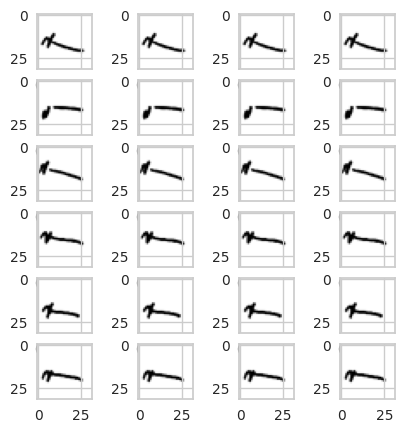

In [6]:
fig, ax = plt.subplots(6,4,figsize=(5,5))

for i in range(6):
    for j in range(4):
        ax[i,j].imshow(x_train[i])

In [7]:
total_classes = len(np.unique(y_train))+1
y_train = to_categorical(y_train,total_classes)
y_test = to_categorical(y_test, total_classes)

print(y_train.shape)
print(y_test.shape)

(13440, 29)
(3360, 29)


In [8]:
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input,Conv1D,Flatten, BatchNormalization,SpatialDropout1D, MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding


class attention(layers.Layer):
    def _init_(self,**kwargs):
        super(attention,self)._init_(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [9]:
from tensorflow.keras.layers import InputLayer,BatchNormalization, Reshape,BatchNormalization
from tensorflow.keras.layers import ReLU,ZeroPadding2D,DepthwiseConv2D,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU,Activation,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
#from tensorflow_addons.layers import AdaptiveAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, GRU, Bidirectional, BatchNormalization, Convolution1D, MaxPooling1D, Reshape

    
model = Sequential([
    
    InputLayer(input_shape=(32,32,1)),
    
    Conv2D(64, (3,3), padding='valid', activation='relu',strides=1,
            kernel_initializer='HeNormal'),
    Conv2D(64, (3,3), padding='valid', activation='relu',strides=1),
    MaxPooling2D((2,2), strides=1),
    BatchNormalization(),

    Conv2D(128, (3,3), padding='valid', activation='relu',strides=1),
    MaxPooling2D((2,2), strides=1),
    BatchNormalization(),
    
    Conv2D(128, (3,3), padding='valid', activation='relu',strides=1),
    MaxPooling2D((2,2), strides=1),
    BatchNormalization(),
    
    Reshape((21, 21 * 128)),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=False)),
    Reshape((1,128), input_shape = (128,)),
    BatchNormalization(),
    Bidirectional(LSTM(32, return_sequences=False)),
    
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(29, activation='softmax')
    
    
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 21, 2688)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 2688)       │        10,752 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │     1,409,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │        29,725 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,310,621 (8.81 MB)

 Trainable params: 2,304,349 (8.79 MB)

 Non-trainable params: 6,272 (24.50 KB)

In [10]:
from keras import backend as K
def ctc_loss(y_true, y_pred):
    return K.ctc_batch_cost(y_true, y_pred, np.ones(batch_size), np.ones(batch_size))


In [11]:
import tensorflow as tf

#opt
#rmsprop
#optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=.9, decay=5e-5)
#loss = tf.keras.losses.binary_crossentropy
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07,decay=5e-5)
#model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.CosineSimilarity(axis=1)])
#model.compile(loss='categorical_crossentropy', optimizer='adam', run_eagerly=True, metrics=['tf.keras.metrics.CosineSimilarity(axis=1)'])
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [12]:
history = model.fit(x_train,y_train,
                    #steps_per_epoch=len(x_train)//128,
                    batch_size=64,
                    epochs=200,
                    validation_data=(x_test, y_test),
                    #validation_steps=50
                   )

Epoch 1/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.3254 - loss: 2.1938 - val_accuracy: 0.4881 - val_loss: 1.7163
Epoch 2/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7539 - loss: 0.7237 - val_accuracy: 0.7119 - val_loss: 0.8609
Epoch 3/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8154 - loss: 0.5398 - val_accuracy: 0.8113 - val_loss: 0.5717
Epoch 4/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8663 - loss: 0.4002 - val_accuracy: 0.7795 - val_loss: 0.6760
Epoch 5/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8782 - loss: 0.3648 - val_accuracy: 0.8497 - val_loss: 0.4988
Epoch 6/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9072 - loss: 0.2740 - val_accuracy: 0.8881 - val_loss: 0.3634
Epoch 7/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9134 - loss: 0.2644 - val_accuracy: 0.8985 - val_loss: 0.3440
Epoch 8/200
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9196 - loss: 0.2371 -

In [13]:
y_held_pred=model.predict(x_test)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [14]:
y_pred=np.argmax(y_held_pred, axis=1)
y_test_1=np.argmax(y_test, axis=1)

print(y_test_1.shape)
print(y_pred.shape)

(3360,)
(3360,)


In [15]:
model.evaluate(x_test,y_test)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9578 - loss: 0.2941


[0.2368696630001068, 0.9616071581840515]

In [16]:
his=model.evaluate(x_test, y_test, verbose=2);
print(his)

105/105 - 1s - 7ms/step - accuracy: 0.9616 - loss: 0.2369
[0.2368696630001068, 0.9616071581840515]


In [17]:
y_held_pred_train=model.predict(x_train)

420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [18]:
y_pred_train=np.argmax(y_held_pred_train, axis=1)
y_train_1=np.argmax(y_train, axis=1)

print(y_train_1.shape)
print(y_pred_train.shape)
model.evaluate(x_train, y_train, verbose=2);

(13440,)
(13440,)
420/420 - 3s - 7ms/step - accuracy: 0.9937 - loss: 0.0230


<Axes: title={'center': 'Actual vs. Predicted'}, xlabel='Actual G*', ylabel='Predicted G*'>

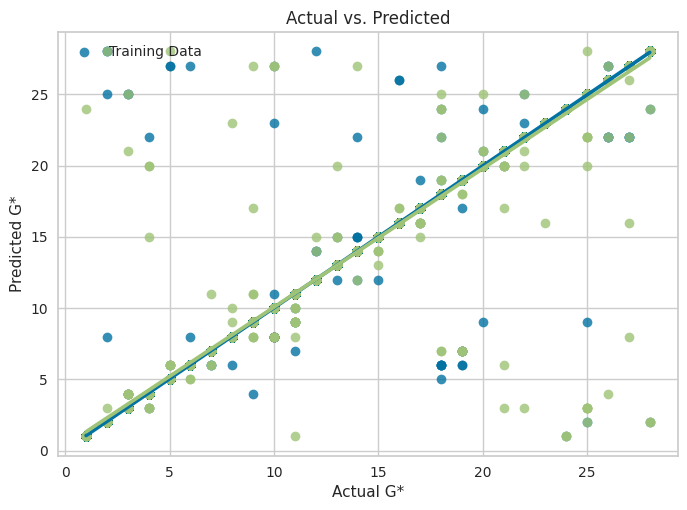

In [19]:
import seaborn as sns

sns.regplot(x=y_train_1,y=y_pred_train, label="Training Data")

plt.xlabel('Actual G*')
plt.ylabel('Predicted G*')
plt.title('Actual vs. Predicted')
plt.legend(loc="upper left")

sns.regplot(x=y_test_1,y=y_pred, label="Testing Data")

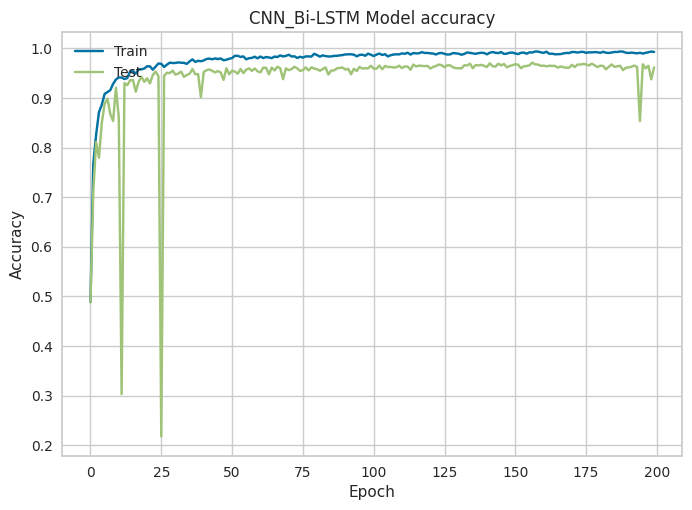

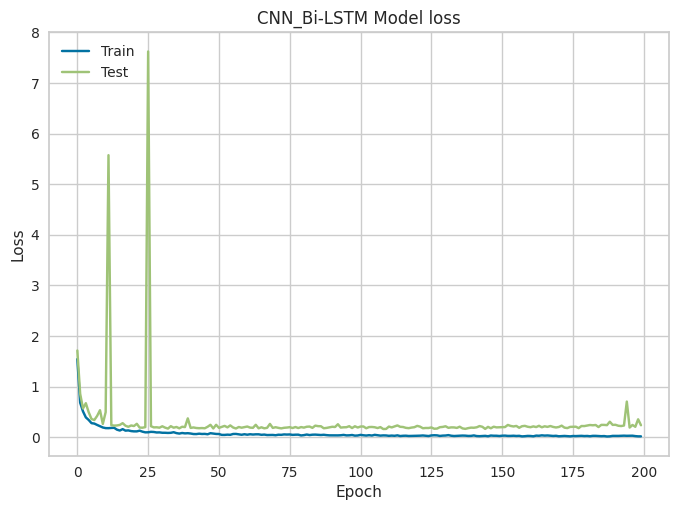

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN_Bi-LSTM Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_Bi-LSTM Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
y_predicted = model.predict(x_test)
y_grand_truth = y_test
y_predicted = np.argmax(y_predicted,axis=1)
y_grand_truth = np.argmax(y_grand_truth,axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_grand_truth, y_predicted)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


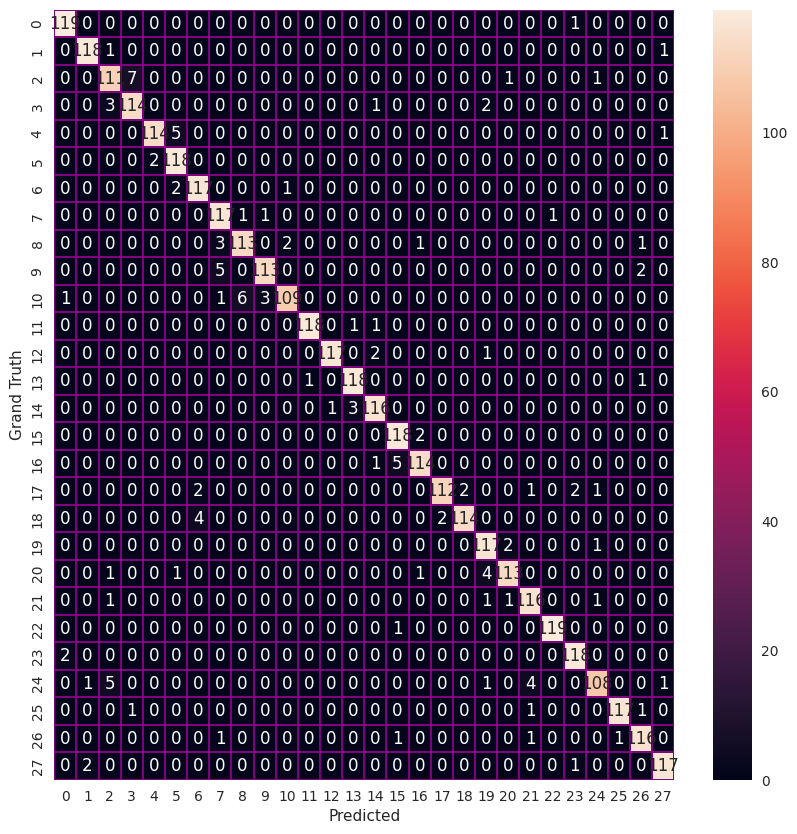

In [24]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.1, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

In [25]:
scores = np.zeros((28,3))
def calc_F1(num):
  TP = cm[num,num]
  FN = np.sum(cm[num,:])-cm[num,num]
  FP = np.sum(cm[:,num])-cm[num,num]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1_score = 2*(recall * precision) / (recall + precision)
  return precision, recall, F1_score
for i in range(28):
   precision, recall, F1_score = calc_F1(i)
   scores[i,:] = precision, recall, F1_score
scores_frame = pd.DataFrame(scores,columns=["Precision", "Recall", "F1 Score"], index=[list(range(0, 28))])

In [26]:
# Functions: Performance Evaluation 

def Performance(Model , y_predd): 
    
    # model accuracy
    accuracy = accuracy_score(y_test_1, y_predd)
    print( Model +' Accuracy:'+'\033[1m {:.2f}%'.format(accuracy*100))
    
    # model Classification Report
    print('\nClassification Report: '+'\033[0m')
    print('*' * 22)
    print(classification_report(y_test_1, y_predd))

In [27]:
Performance('CNN_Bi-LSTM' , y_pred)

CNN_Bi-LSTM Accuracy: 96.16%

Classification Report: 
**********************
              precision    recall  f1-score   support

           1       0.98      0.99      0.98       120
           2       0.98      0.98      0.98       120
           3       0.91      0.93      0.92       120
           4       0.93      0.95      0.94       120
           5       0.98      0.95      0.97       120
           6       0.94      0.98      0.96       120
           7       0.95      0.97      0.96       120
           8       0.92      0.97      0.95       120
           9       0.94      0.94      0.94       120
          10       0.97      0.94      0.95       120
          11       0.97      0.91      0.94       120
          12       0.99      0.98      0.99       120
          13       0.99      0.97      0.98       120
          14       0.97      0.98      0.98       120
          15       0.96      0.97      0.96       120
          16       0.94      0.98      0.96       120
    